In [14]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.compat import pickle_compat
from scipy.signal import welch, butter, filtfilt

# Helper functions

In [15]:

# -------------------------
#  Helper function to select LFP and Spikes epochs to be plotted
# -------------------------
def select_epoch(df, session=None, epoch_label=None, epoch_idx=None, row_idx=None):
    """
    Pick one epoch row either by row_idx (direct) or by filtering session/epoch_label/epoch_idx.
    """
    print("Available sessions:", df["session"].unique())
    print("Available epoch labels:", df["epoch_label"].unique())
    print("Available epoch idx:", df["epoch_idx"].unique())

    print("Selecting epoch with filters - session:", session, "epoch_label:", epoch_label, "epoch_idx:", epoch_idx, "row_idx:", row_idx)
    
    if row_idx is not None:
        assert epoch_label is None 
        assert epoch_idx is None
        assert epoch_label is None
        return df.iloc[int(row_idx)]

    sub = df.copy()
    if session is not None:
        sub = sub[sub["session"] == session]
    else:
        print("No session filter applied, using all sessions.")
    if epoch_label is not None:
        sub = sub[sub["epoch_label"] == epoch_label]
    else:
        print("No epoch_label filter applied, using all epoch labels.")
    if epoch_idx is not None:
        sub = sub[sub["epoch_idx"] == epoch_idx]
    else:
        print("No epoch_idx filter applied, using all epoch idx.")

    if len(sub) == 0:
        raise ValueError("No epoch matched your filters. Try different session/epoch_label/epoch_idx or use row_idx.")
    return sub.iloc[0]


# -------------------------
# Helper Function to plot the  Plot LFPs + 3 rasters of single units per brain region
# -------------------------
def plot_lfp_and_one_unit_per_region(
    epoch_row,
    fs=1250,
    xlim=None,                 # e.g. (7260, 7265, if you know the interval you would like to plot) to plot an interval for vizualization I recommend using the example in the plot bellow
    lfp_ylim=None,
    unit_ids=None,             # dict like {"bla": 66, "vHPC": 1057, "dHPC": 1690}; if None -> first unit in each dict
    title_prefix=""
):
    """
    Plots:
      - LFP traces for BLA, vHPC, dHPC 
      - Raster for ONE unit per region (first unit in each dict by default)

    Notes:
      - epoch_row['time_epoch'] is used as x-axis (usually absolute seconds).
      - spikes dict values are arrays of spike times (same time base as time_epoch).
    """
    t = np.asarray(epoch_row["time_epoch"])
    lfp_bla  = np.asarray(epoch_row["bla_lfp"])
    lfp_vhpc = np.asarray(epoch_row["vHPC_lfp"])
    lfp_dhpc = np.asarray(epoch_row["dHPC_lfp"])

    spikes_bla  = epoch_row["spikes_bla"]
    spikes_vhpc = epoch_row["spikes_vHPC"]
    spikes_dhpc = epoch_row["spikes_dHPC"]

    # Pick one unit per region (default = first key, but you can also directly name the unit by placing its ID as shown in the example bellow ) 
    if unit_ids is None:
        unit_ids = {
            "bla":  next(iter(spikes_bla.keys()))  if isinstance(spikes_bla, dict) and len(spikes_bla) else None,
            "vHPC": next(iter(spikes_vhpc.keys())) if isinstance(spikes_vhpc, dict) and len(spikes_vhpc) else None,
            "dHPC": next(iter(spikes_dhpc.keys())) if isinstance(spikes_dhpc, dict) and len(spikes_dhpc) else None,
        }

    # Grab spike arrays  = Note that sometimes the (may be empty  if the unit you select does not have spikes in the selected interval, so if you run and the units plot show nothing...
    # It can be that this unit in the selected interval does not have any spikes, Which can happen, sometimes, more than we wish for. 

    sp_bla  = np.asarray(spikes_bla.get(unit_ids["bla"],  [])) if unit_ids["bla"] is not None else np.array([])
    sp_vhpc = np.asarray(spikes_vhpc.get(unit_ids["vHPC"], [])) if unit_ids["vHPC"] is not None else np.array([])
    sp_dhpc = np.asarray(spikes_dhpc.get(unit_ids["dHPC"], [])) if unit_ids["dHPC"] is not None else np.array([])

    # Colors (seaborn palette)
    colors = sns.color_palette("husl", 3)

    fig, axes = plt.subplots(
        nrows=6, ncols=1, figsize=(18, 12),
        sharex=True, gridspec_kw={"height_ratios": [1, 1, 1, 0.6, 0.6, 0.6]}
    )

    # --- LFPs
    axes[0].plot(t, lfp_bla)
    axes[0].set_ylabel("BLA LFP")
    axes[0].set_ylim(lfp_ylim)

    axes[1].plot(t, lfp_vhpc)
    axes[1].set_ylabel("vHPC LFP")
    axes[1].set_ylim(lfp_ylim)

    axes[2].plot(t, lfp_dhpc)
    axes[2].set_ylabel("dHPC LFP")
    axes[2].set_ylim(lfp_ylim)

    # --- Rasters (one unit each)
    axes[3].eventplot(sp_bla,  lineoffsets=0, linelengths=0.8, color=colors[0])
    axes[3].set_yticks([])
    axes[3].set_ylabel(f"BLA\nunit {unit_ids['bla']}")

    axes[4].eventplot(sp_vhpc, lineoffsets=0, linelengths=0.8, color=colors[1])
    axes[4].set_yticks([])
    axes[4].set_ylabel(f"vHPC\nunit {unit_ids['vHPC']}")

    axes[5].eventplot(sp_dhpc, lineoffsets=0, linelengths=0.8, color=colors[2])
    axes[5].set_yticks([])
    axes[5].set_ylabel(f"dHPC\nunit {unit_ids['dHPC']}")
    axes[5].set_xlabel("Time (s)")

    # x-limits
    if xlim is not None:
        for ax in axes:
            ax.set_xlim(xlim)

    # Title with metadata if present
    meta = []
    for k in ["Session", "Epoch Label", "Epoch Idx", "T_start", "T_end"]:
        if k in epoch_row.index:
            meta.append(f"{k}={epoch_row[k]}")
    fig.suptitle((title_prefix + " | " if title_prefix else "") + "  ".join(meta), y=0.98)

    plt.tight_layout()
    plt.show()

    return unit_ids  # Here in case you choose to plot the units per row idx, still possible to double check wich one you selected and was used

# Example 1 : Plotting LFP Signal

We can start by loading the data .pkl and explore the structure of the dataset

In [16]:
# -------------------------
# 1) Load your .pkl file
# -------------------------
pkl_path = "data/lfp_data.pkl" # You should place here the path to where the .pkl file with the LFP/Single unit information is :D
pkl_path_aversive = "data/lfp_epochs_with_spikes_by_region_aversive.pkl" # You should place here the path to where the .pkl file with the LFP/Single unit information is :D
pkl_path_rewarded = "data/lfp_epochs_with_spikes_by_region_session_rewarded.pkl" # You should place here the path to where the .pkl file with the LFP/Single unit information is :D

df = pd.read_pickle(pkl_path_rewarded)

# In case you want to vizualize the data table headers and shape just uncomment bellow
print("Shape of the dataset \n")
print(df.shape, "\n")
print("Columns name \n")
print(df.columns.tolist(), "\n")
print("Example LFP signal \n")
print(df['bla_lfp'][0])
print("Shape :", df['bla_lfp'][0].shape, "\n")
print('As you can see its just a 1D temporal serie where each .\n')
print('Example neuron activity \n')
print(df['spikes_bla'][0][66])
print("Shape :", df['spikes_bla'][0][66].shape, "\n")
print("As you can see the shape is different, this is because spikes are reported as spike times. So each point in the array is the timing of a spike.")


Shape of the dataset 

(26, 12) 

Columns name 

['session', 'epoch_label', 'epoch_idx', 't_start', 't_end', 'time_epoch', 'bla_lfp', 'dHPC_lfp', 'vHPC_lfp', 'spikes_bla', 'spikes_vHPC', 'spikes_dHPC'] 

Example LFP signal 

[-153.61919675   45.04056086   30.09815017 ...  -52.7991075  -130.36026822
   19.02098175]
Shape : (113751,) 

As you can see its just a 1D temporal serie where each .

Example neuron activity 

[7260.02485 7260.0301  7260.08875 ... 7350.9421  7350.94685 7350.95135]
Shape : (2044,) 

As you can see the shape is different, this is because spikes are reported as spike times. So each point in the array is the timing of a spike.


We can now plot the different signals all together. Feel free to explore the different options to parse throught the dataset. 

For now ze'll plot only a 1 second window, between 10 and 11s after the start of the epoch as seen in the value of xlim. You may want to look at the data through different time scales. 

If you want to visualize the spiking actvivities of different units, you can change the selection in unit_ids (one cell per brain region).

Available sessions: ['08']
Available epoch labels: ['REM I' 'REM II' 'NREM I' 'NREM II']
Available epoch idx: [0 1 2 3 4 5 6 7]
Selecting epoch with filters - session: 08 epoch_label: NREM I epoch_idx: 5 row_idx: None


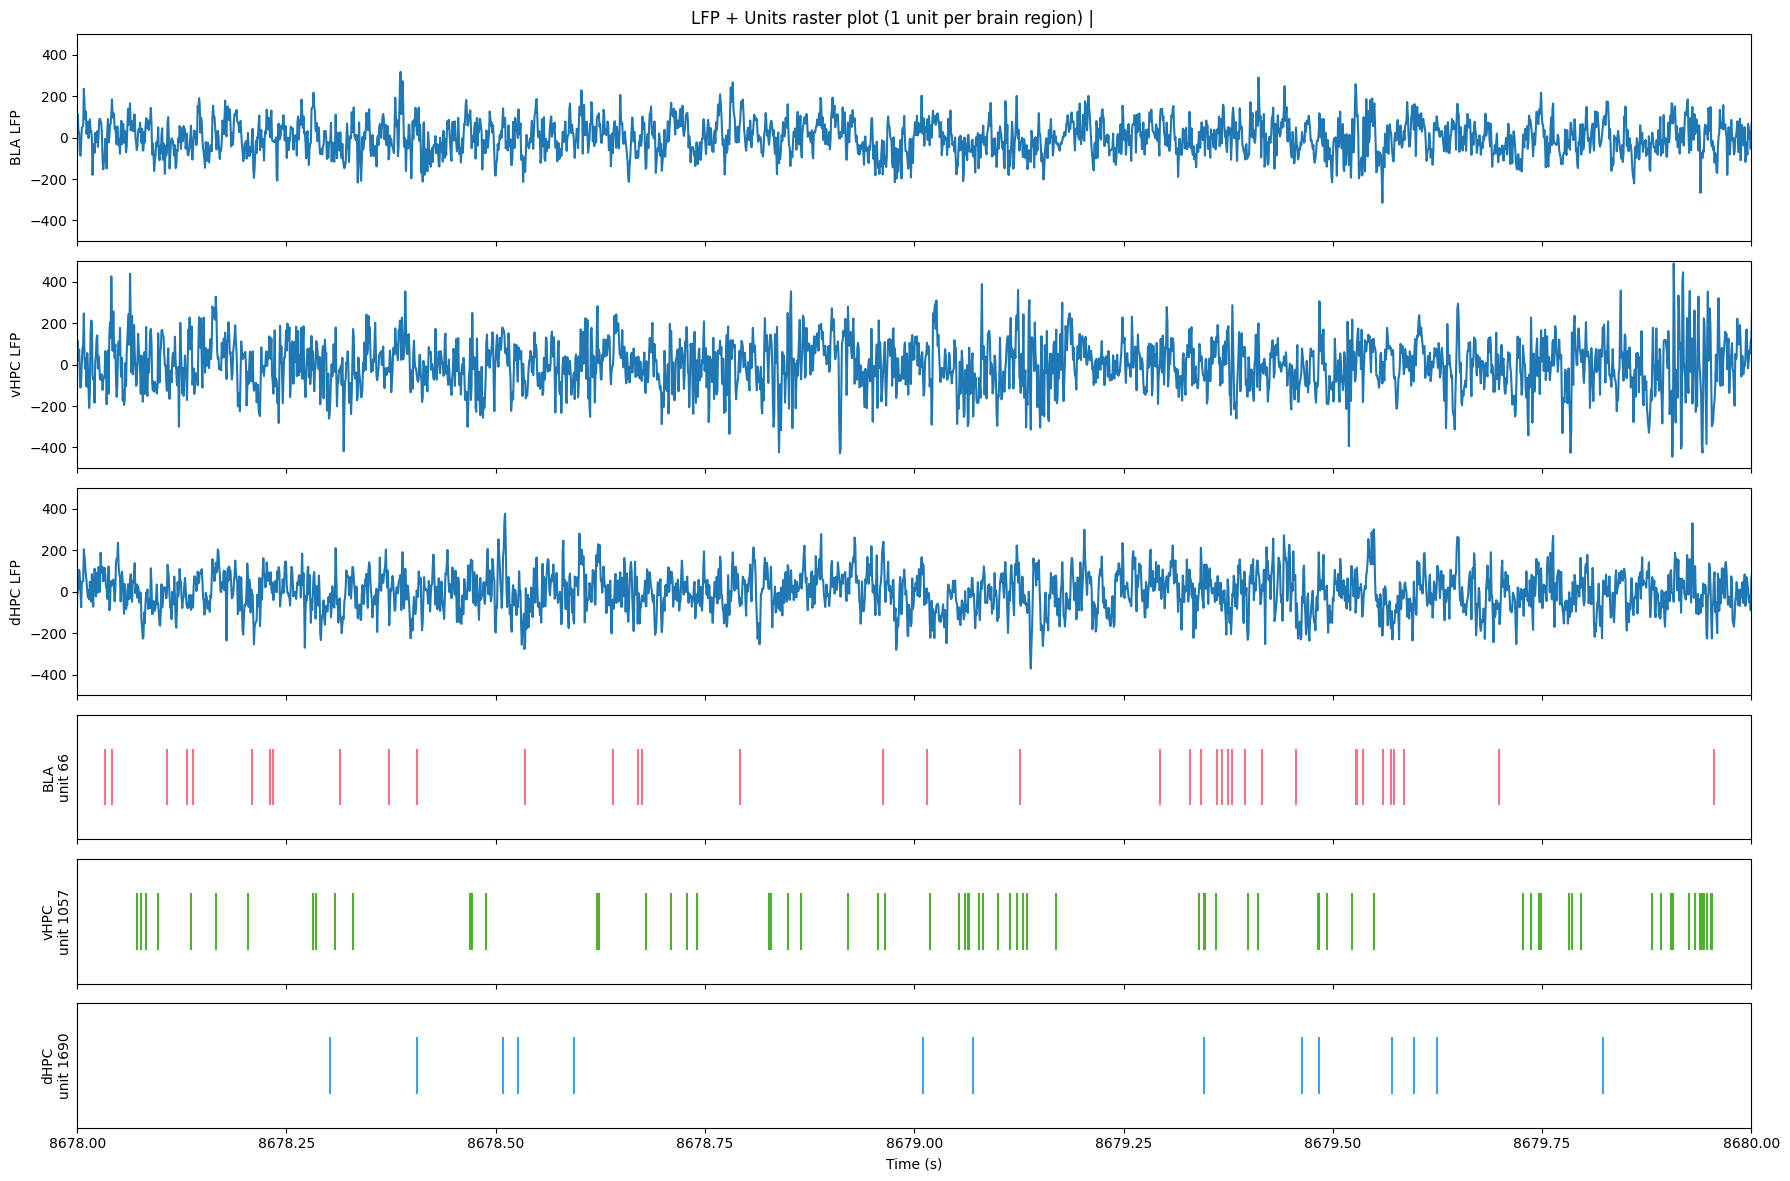

In [26]:
# -------------------------
# 4) Finally hands on , lets see the data \o/
# -------------------------

# Option A: pick an epoch by row index 
# epoch = select_epoch(df, row_idx=0)

# Option B: pick by filters
epoch = select_epoch(df, session="08", epoch_label="NREM I", epoch_idx=5)

# To plot a 5 seconds window set xlim=(epoch["t_start"]+10, epoch["t_start"]+15). 
# Like that you are selecting an interval of 5 seconds, in the plot bellow we using an interval of one second to vizualize better the LFP

# Et voilà! 

chosen_units = plot_lfp_and_one_unit_per_region(
    epoch_row=epoch,
    fs=1250,
    xlim=(epoch["t_start"] + 10, epoch["t_start"] + 12),  # Here the X is settle to 1 second but you can play around with different time scales 
    lfp_ylim=(-500, 500),
    unit_ids={"bla": 66, "vHPC": 1057, "dHPC": 1690} ,# None - In case you want to plot just the first unit of each brain  region
    title_prefix= "LFP + Units raster plot (1 unit per brain region)"
)

# Example 2 : Making neuron activity a continuous signal

You maybe will want to convert neuronal activity in the same format as the LFP, note that is a bit destructive since exacts spike times tend to be relevant.

Recording window: 7260.000s → 7351.000s


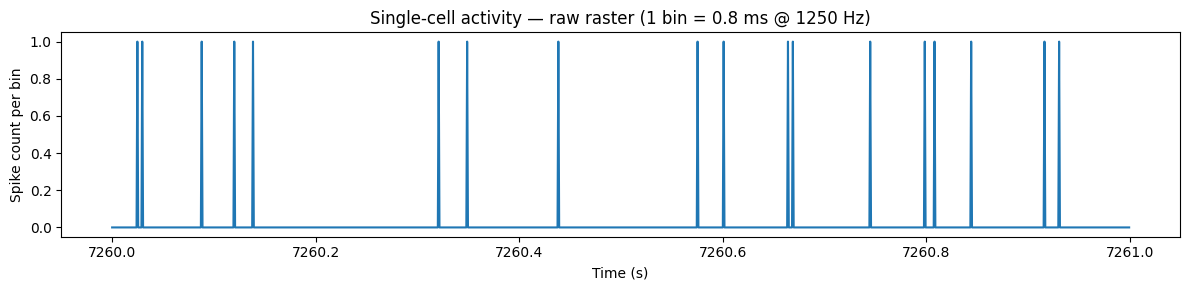

In [28]:
# =============================================================================
# SPIKE TIMES → PSTH (Peri-Stimulus Time Histogram)
# =============================================================================
# Spike times are stored as timestamps (in seconds). To analyze neural activity,
# we convert them into a binary array (1 bin = 1 LFP sample at 1250 Hz),
# where each bin is 1 if a spike occurred, 0 otherwise.

# --- Extract data ---
ex_cell_spike_times = df['spikes_bla'][0][66]  # Spike timestamps (in seconds) for one example cell
t_start = df['t_start'][0]                     # Start time of the recording epoch (seconds)
t_end   = df['t_end'][0]                       # End time of the recording epoch (seconds)
print(f"Recording window: {t_start:.3f}s → {t_end:.3f}s")

# --- Build the time axis ---
FS = 1250                                      # Sampling frequency of the LFP recording (Hz)
n_bins = int((t_end - t_start) * FS)          # Total number of time bins

# --- Align spike times to the recording window ---
relative_spike_times = ex_cell_spike_times - t_start
# Subtracting t_start makes all times relative to the start of the window (t=0).

# --- Initialise the raster array with zeros ---
raster_cell_activity = np.zeros(n_bins)

# --- Fill the raster: place each spike in its corresponding bin ---
for spike_time in relative_spike_times:
    index = int(spike_time * FS)              # Convert seconds → sample index

    # Guard against spikes that fall exactly on t_end or due to floating-point
    # rounding land one sample beyond the array boundary
    if 0 <= index < n_bins:
        raster_cell_activity[index] += 1

# --- Visualise ---
time_axis = np.linspace(t_start, t_end, n_bins)  # Real time axis for the x-axis label

plt.figure(figsize=(12, 3))
plt.plot(time_axis[0:1250], raster_cell_activity[0:1250])
plt.xlabel("Time (s)")
plt.ylabel("Spike count per bin")
plt.title("Single-cell activity — raw raster (1 bin = 0.8 ms @ 1250 Hz)")
plt.tight_layout()
plt.show()

# Example 3 : Find theta waves in LFP

The Local Field Potential (LFP) is a raw voltage signal that reflects the summed electrical activity of many neurons near the electrode. It contains many different oscillations mixed together (delta, theta, gamma, etc.).
Our goal here is to ISOLATE the theta band (4–12 Hz in rodents) from the rest of the signal using a bandpass filter.

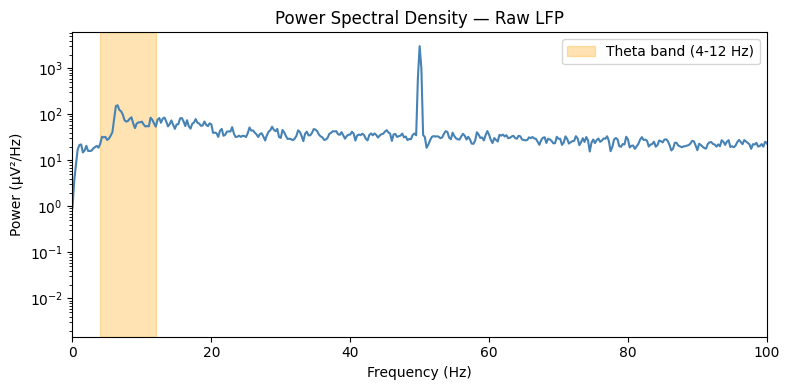

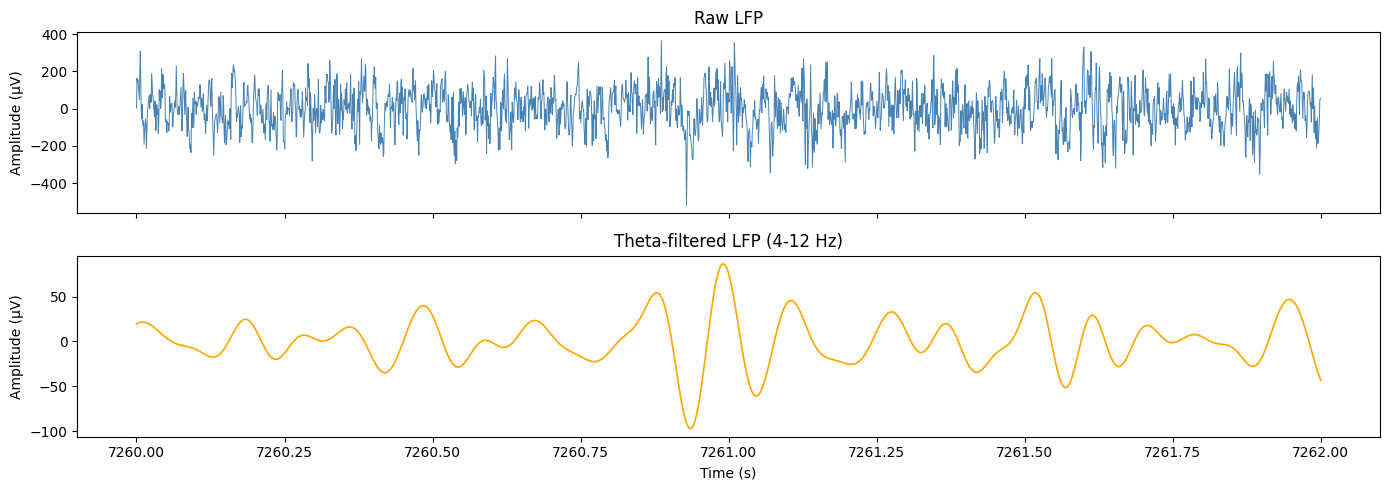

In [19]:
# =============================================================================
# STEP 1 — CHECK THE POWER SPECTRUM (which frequencies are present?)
# =============================================================================
# Before filtering, it's good practice to look at the Power Spectral Density
# (PSD): it shows how much signal "energy" lives at each frequency.
# A clear bump in the 4–12 Hz range confirms theta is present.
#
# We use Welch's method: it splits the signal into overlapping chunks,
# computes the FFT on each, and averages them → much smoother than a raw FFT.

# --- Extract the raw LFP signal ---
lfp = df['dHPC_lfp'][0]           # Raw LFP signal, shape: (n_samples,)
FS  = 1250                       # Sampling frequency (Hz) — same as before

# Build a real time axis so our x-axis is in seconds, not sample numbers
t_start = df['t_start'][0]
t_end   = df['t_end'][0]
time_axis = np.linspace(t_start, t_end, len(lfp))

freqs, psd = welch(
    lfp,
    fs       = FS,
    nperseg  = 4 * FS,   # Each chunk is 4 seconds long (more freq. resolution)
    noverlap = 2 * FS    # Chunks overlap by 2 seconds (smoother estimate)
)

plt.figure(figsize=(8, 4))
plt.semilogy(freqs, psd, color='steelblue')          # log y-axis: brain PSD spans decades
plt.axvspan(4, 12, color='orange', alpha=0.3, label='Theta band (4-12 Hz)')
plt.xlim(0, 100)                                      # Focus on 0–100 Hz
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (µV²/Hz)")
plt.title("Power Spectral Density — Raw LFP")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 2 — DESIGN A BANDPASS FILTER (4–12 Hz)
# =============================================================================
# A bandpass filter keeps only the frequencies between two cutoffs and
# attenuates everything else.
#
# We use a BUTTERWORTH filter: it has a maximally flat response in the
# passband, meaning it doesn't distort the frequencies we want to keep.
#
# Key parameters:
#   N      = filter order → higher = steeper roll-off, but can cause ringing
#   Wn     = [low, high] cutoff frequencies, normalised by the Nyquist freq.
#             Nyquist = FS/2 = 625 Hz (the highest freq. we can represent)
#   btype  = 'bandpass' keeps only frequencies between low and high

THETA_LOW  = 4    # Hz — lower edge of theta band
THETA_HIGH = 12   # Hz — upper edge of theta band
FILTER_ORDER = 4  # A good default: steep enough without ringing

nyquist = FS / 2
b, a = butter(
    N      = FILTER_ORDER,
    Wn     = [THETA_LOW / nyquist, THETA_HIGH / nyquist],
    btype  = 'bandpass'
)
# b, a are the filter coefficients that define the filter's behaviour.
# You don't need to understand the math behind them — scipy computes them for you.

# =============================================================================
# STEP 3 — APPLY THE FILTER
# =============================================================================
# We use filtfilt() instead of lfilter().
# Why? filtfilt applies the filter TWICE — once forward, once backward —
# which cancels out any phase shift. This means peaks in the filtered signal
# stay aligned with peaks in the raw signal. Always prefer filtfilt for
# neuroscience analysis.

theta_lfp = filtfilt(b, a, lfp)

# =============================================================================
# STEP 4 — VISUALISE RAW vs THETA
# =============================================================================
# We plot a short window (2 seconds) so individual oscillation cycles are visible.
# At 4–12 Hz, one cycle lasts between 83 ms and 250 ms — easy to see at this zoom.

WINDOW_START = t_start           # seconds — change this to explore other parts
WINDOW_END   = t_start + 2       # show 2 seconds

mask = (time_axis >= WINDOW_START) & (time_axis <= WINDOW_END)

fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True)

axes[0].plot(time_axis[mask], lfp[mask], lw=0.7, color='steelblue')
axes[0].set_ylabel("Amplitude (µV)")
axes[0].set_title("Raw LFP")

axes[1].plot(time_axis[mask], theta_lfp[mask], lw=1.2, color='orange')
axes[1].set_ylabel("Amplitude (µV)")
axes[1].set_xlabel("Time (s)")
axes[1].set_title("Theta-filtered LFP (4-12 Hz)")

plt.tight_layout()
plt.show()

In [80]:
pkl_path_aversive = "data\lfp_epochs_with_spikes_by_region-av-2.pkl" # You should place here the path to where the .pkl file with the LFP/Single unit information is :D

with open(pkl_path_aversive, "rb") as f:
    df = pickle_compat.load(f)

print(df.head())

  session epoch_label  epoch_idx  t_start   t_end  \
0      08       REM I          0   2644.0  2704.0   
1      08       REM I          1   2926.0  3014.0   
2      08       REM I          2   3143.0  3250.0   
3      08       REM I          3   3974.0  4000.0   
4      08       REM I          4   4079.0  4280.0   

                                          time_epoch  \
0  [2644.0, 2644.0008000000003, 2644.0016, 2644.0...   
1  [2926.0, 2926.0008000000003, 2926.0016, 2926.0...   
2  [3143.0, 3143.0008000000003, 3143.0016, 3143.0...   
3  [3974.0, 3974.0008000000003, 3974.0016, 3974.0...   
4  [4079.0, 4079.0008000000003, 4079.0016, 4079.0...   

                                             bla_lfp  \
0  [-22.907072436816463, -29.30111259147509, -94....   
1  [-2.7496611542812275, 117.98764540927965, 5.90...   
2  [-84.84061899660507, -178.0472438626934, -116....   
3  [-35.386775609204506, 1.1929148924929223, -33....   
4  [29.66908818181804, 42.61478455299874, 17.8757...   

       

0.16059984323585944


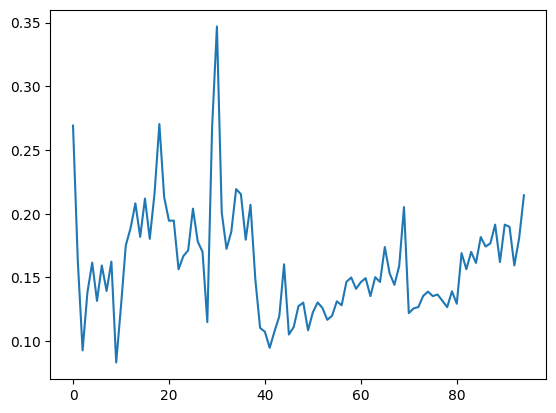

In [81]:
def compute_lfp_correlation(df,name1,name2): 
    bla = df[name1]
    dHPC = df[name2]
    long = bla.shape[0]
    correlation_values = []
    for i in range(long):
        bla_i = bla[i]
        dHPC_i = dHPC[i]
        correlation_values.append(np.corrcoef(bla_i, dHPC_i)[0, 1])
    return correlation_values

correlation_values = compute_lfp_correlation(df,'vHPC_lfp','dHPC_lfp')
plt.plot(correlation_values)
print(np.mean(np.array(correlation_values)))